In [1]:
import warnings
import os
from functools import reduce
from operator import __add__
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import Omniglot, CIFAR10
import torch.nn as nn
import torch.nn.functional as F
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid

from unsupervised_meta_learning.nn_utils import c_imshow
from unsupervised_meta_learning.pl_dataloaders import (UnlabelledDataModule,
                                                       UnlabelledDataset)
from unsupervised_meta_learning.proto_utils import (CAE, get_prototypes,
                                                    prototypical_loss)
from unsupervised_meta_learning.protoclr import ProtoCLR


/home/ojas/anaconda3/envs/ai/lib/python3.9/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


In [2]:
kernel_sizes = (3, 3)
conv_padding = reduce(__add__, [(k // 2 + (k - 2 * (k // 2)) - 1, k // 2) for k in kernel_sizes[::-1]])

class Encoder(nn.Module):
    def __init__(self, in_channels=1, hidden_size=64, out_channels=64):
        super().__init__()

        self.encoder = nn.Sequential(
            # nn.ZeroPad2d(conv_padding),
            nn.Conv2d(in_channels, hidden_size, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(),
            nn.MaxPool2d(2), # 14 x 14

            # nn.ZeroPad2d(conv_padding),
            nn.Conv2d(hidden_size, hidden_size, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(),
            nn.MaxPool2d(2), # 7x7

            # nn.ZeroPad2d(conv_padding),
            nn.Conv2d(hidden_size, hidden_size, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(),
            nn.MaxPool2d(2), #3x3

            # nn.ZeroPad2d(conv_padding),
            nn.Conv2d(hidden_size, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2), #1x1
        )
    def forward(self, inputs):
        return self.encoder(inputs)

class Decoder(nn.Module):
    def __init__(self, in_channels=1, hidden_size=64, out_channels=64):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.UpsamplingNearest2d(size=(4, 4)),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(),

            nn.UpsamplingNearest2d(size=(7, 7)),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(),

            nn.UpsamplingNearest2d(size=(14, 14)),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(),

            nn.UpsamplingNearest2d(size=(28, 28)),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding='same'),
            nn.BatchNorm2d(in_channels),
            nn.Sigmoid()
        )
    def forward(self, inputs):
        return self.decoder(inputs)
        
class AE(nn.Module):
    def __init__(self, in_channels=1, hidden_size=64, out_channels=64):
        super().__init__()

        self.encoder = Encoder(in_channels=in_channels, hidden_size=hidden_size, out_channels=out_channels)
        self.decoder = Decoder(in_channels=in_channels, hidden_size=hidden_size, out_channels=out_channels)

    def forward(self, inputs):
        print(inputs.shape)
        embeddings = self.encoder(inputs.view(-1, *inputs.shape[-3:]))
        print(embeddings.shape)
        recons = self.decoder(embeddings.unsqueeze(-1).unsqueeze(-1))
        return embeddings.view(*inputs.shape[:-3], -1), recons.view(*inputs.shape)

In [4]:
class Encoder(nn.Module):

    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int,
                 act_fn : object = nn.GELU):
        """
        Inputs:
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2), # 32x32 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 8x8 => 4x4
            act_fn(),
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(2*16*c_hid, latent_dim)
        )

    def forward(self, x):
        return self.net(x)

In [3]:
class Decoder(nn.Module):

    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int,
                 act_fn : object = nn.GELU):
        """
        Inputs:
            - num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 2*16*c_hid),
            act_fn()
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(2*c_hid, 2*c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 4x4 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2*c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 8x8 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2), # 16x16 => 32x32
            nn.Tanh() # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x

In [43]:
class Autoencoder(pl.LightningModule):

    def __init__(self,
                 base_channel_size: int,
                 latent_dim: int,
                 encoder_class : object = Encoder,
                 decoder_class : object = Decoder,
                 num_input_channels: int = 1,
                 width: int = 28,
                 height: int = 28):
        super().__init__()
        # Saving hyperparameters of autoencoder
        self.save_hyperparameters()
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)
        # Example input array needed for visualizing the graph of the network
        self.example_input_array = torch.zeros(2, num_input_channels, width, height)

    def forward(self, x):
        """
        The forward function takes in an image and returns the reconstructed image
        """
        # print(x.shape)
        z = self.encoder(x.view(-1, *x.shape[-3:]))
        x_hat = self.decoder(z)
        # z = self.encoder(x)
        # x_hat = self.decoder(z)
        return x_hat.view(*x.shape)

    def _get_reconstruction_loss(self, batch, ways, n_supp, n_query):
        """
        Given a batch of images, this function returns the reconstruction loss (MSE in our case)
        """
        x, _ = batch # We do not need the labels
        x_hat = self.forward(x)

        x_supp = x[:,:ways * n_supp]
        r_supp = x_hat[:,:ways * n_supp]
        r_query = x_hat[:,ways * n_supp:]
        # print("####", r_supp.shape, r_query.shape)

        r_query = r_query.view(1, r_supp.shape[1], 3, 1, 28, 28)



        # loss = F.mse_loss(x.squeeze(0), x_hat, reduction='none').sum(dim=[1, 2, 3,]).mean(dim=[0])
        loss = F.mse_loss(
                r_query,
                torch.broadcast_to(x_supp.unsqueeze(2), r_query.shape),
                reduction='none').sum(dim=[1, 2, 3, 4, 5]).mean(dim=[0])
        # loss = F.mse_loss(
        #         r_supp, 
        #         x_supp,
        #         reduction='none').sum(dim=[1, 2, 3, 4,]).mean(dim=[0])

        # loss = F.mse_loss(x, x_hat, reduction="none")
        # loss = loss.sum(dim=[1,2,3]).mean(dim=[0])
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                         mode='min',
                                                         factor=0.2,
                                                         patience=20,
                                                         min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "train_loss"}

    def training_step(self, batch, batch_idx):
        data = batch['data'].to(self.device) # [batch_size x ways x shots x image_dim]
        data = data.unsqueeze(0)
        # e.g. 50 images, 2 support, 2 query, miniImageNet: torch.Size([1, 50, 4, 3, 84, 84])
        batch_size = data.size(0)
        ways = data.size(1)
        x_support = data[:,:,:1]
        x_support = x_support.reshape((batch_size, ways * 1, *x_support.shape[-3:])) # e.g. [1,50*n_support,*(3,84,84)]
        x_query = data[:,:,1:]
        x_query = x_query.reshape((batch_size, ways * 3, *x_query.shape[-3:])) # e.g. [1,50*n_query,*(3,84,84)]
        # print(f'!!!! {x_support.shape}')
        # Create dummy query labels
        y_query = torch.arange(ways).unsqueeze(0).unsqueeze(2) # batch and shot dim
        y_query = y_query.repeat(batch_size, 1, 1)
        y_query = y_query.view(batch_size, -1).to('cuda')

        y_support = torch.arange(ways).unsqueeze(0).unsqueeze(2) # batch and shot dim
        y_support = y_support.repeat(batch_size, 1, 1)
        y_support = y_support.view(batch_size, -1).to('cuda')
        x = torch.cat([x_support, x_query], 1) # e.g. [1,50*(n_support+n_query),*(3,84,84)]

        loss = self._get_reconstruction_loss((x, y_support), ways, 1, 3)
        self.log('train_loss', loss)
        return loss

    # def validation_step(self, batch, batch_idx):
    #     loss = self._get_reconstruction_loss(batch)
    #     self.log('val_loss', loss)

    # def test_step(self, batch, batch_idx):
    #     loss = self._get_reconstruction_loss(batch)
    #     self.log('test_loss', loss)

In [44]:
class GenerateCallback(pl.Callback):

    def __init__(self, input_imgs, every_n_epochs=1):
        super().__init__()
        self.input_imgs = input_imgs # Images to reconstruct during training
        self.every_n_epochs = every_n_epochs # Only save those images every N epochs (otherwise tensorboard gets quite large)

    def on_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            # Reconstruct images
            input_imgs = self.input_imgs.to(pl_module.device)
            with torch.no_grad():
                pl_module.eval()
                reconst_imgs = pl_module(input_imgs)
                pl_module.train()
            # Plot and add to tensorboard
            imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
            grid = torchvision.utils.make_grid(imgs, nrow=2,)#  normalize=True, range=(-1,1))
            trainer.logger.experiment.add_image("Reconstructions", grid, global_step=trainer.global_step)

In [30]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = Omniglot(root='./data/untarred', background=False, transform=transform, download=True)
pl.seed_everything(42)
# train_set, val_set = torch.utils.data.random_split(train_dataset, [45000, 5000])

# Loading the test set
# test_set = Omniglot(root='./data/untarred', background=True, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
# val_loader = DataLoader(val_set, batch_size=50, shuffle=False, drop_last=False, num_workers=4)
# test_loader = DataLoader(test_set, batch_size=50, shuffle=False, drop_last=False, num_workers=4)

def get_train_images(num):
    return torch.stack([train_dataset[i][0] for i in range(num)], dim=0)

Global seed set to 42


Files already downloaded and verified


In [31]:
dataset_train = UnlabelledDataset(
    dataset='omniglot',
    datapath='./data/untarred/',
    split='train',
    n_support=1,
    n_query=3
)
dataloader_train = DataLoader(dataset_train,
                                      batch_size=50,
                                      shuffle=True,
                                      num_workers=8,
                                      pin_memory=torch.cuda.is_available())

In [36]:
def get_train_images(num):
    return torch.stack([dataset_train[i]['data'][0] for i in range(num)], dim=0)

In [45]:
device = 'cuda'
def train_omni(latent_dim):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join('./ckpts/', f"omniglot_{latent_dim}"),
                         gpus=1 if str(device).startswith("cuda") else 0,
                         max_epochs=500,
                         callbacks=[ModelCheckpoint(save_weights_only=True),
                                    GenerateCallback(get_train_images(8), every_n_epochs=10),
                                    LearningRateMonitor("epoch")])
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join('./ckpts/', f"omniglot_{latent_dim}.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = Autoencoder.load_from_checkpoint(pretrained_filename)
    else:
        model = Autoencoder(base_channel_size=64, latent_dim=latent_dim)
        trainer.fit(model, dataloader_train,)
    # Test best model on validation and test set
    # val_result = trainer.test(model, test_dataloaders=val_loader, verbose=False)
    # test_result = trainer.test(model, test_dataloaders=test_loader, verbose=False)
    # result = {"test": test_result, "val": val_result}
    return model

In [46]:
train_omni(64)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | In sizes       | Out sizes     
----------------------------------------------------------------------
0 | encoder | Encoder | 111 K  | [2, 1, 28, 28] | [2, 64, 1, 1] 
1 | decoder | Decoder | 111 K  | [2, 64, 1, 1]  | [2, 1, 28, 28]
----------------------------------------------------------------------
223 K     Trainable params
0         Non-trainable params
223 K     Total params
0.895     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Autoencoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
      (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): BatchNorm2d(64, eps=1e-05, mome

In [33]:
dataset_train = UnlabelledDataset(
    dataset='omniglot',
    datapath='./data/untarred/',
    split='train',
    n_support=1,
    n_query=3
)
dataloader_train = DataLoader(dataset_train,
                                      batch_size=50,
                                      shuffle=True,
                                      num_workers=8,
                                      pin_memory=torch.cuda.is_available())

In [8]:
x = next(iter(dataloader_train))

In [9]:
data = x['data'] # [batch_size x ways x shots x image_dim]

In [10]:
data = data.unsqueeze(0)

In [11]:
data.shape

torch.Size([1, 50, 4, 1, 28, 28])

In [12]:
batch_size = data.size(0)
ways = data.size(1)

In [13]:
batch_size, ways

(1, 50)

In [14]:
x_support = data[:,:,:1]
x_support = x_support.reshape((batch_size, ways * 1, *x_support.shape[-3:])) # e.g. [1,50*n_support,*(3,84,84)]
x_query = data[:,:,1:]
x_query = x_query.reshape((batch_size, ways * 3, *x_query.shape[-3:])) # e.g. [1,50*n_query,*(3,84,84)]

# Create dummy query labels
y_query = torch.arange(ways).unsqueeze(0).unsqueeze(2) # batch and shot dim
y_query = y_query.repeat(batch_size, 1, 1)
y_query = y_query.view(batch_size, -1).to('cuda')

y_support = torch.arange(ways).unsqueeze(0).unsqueeze(2) # batch and shot dim
y_support = y_support.repeat(batch_size, 1, 1)
y_support = y_support.view(batch_size, -1).to('cuda')

In [11]:
x_support.shape

torch.Size([1, 50, 1, 28, 28])

In [15]:
x_support[0][0].shape, x_query.reshape(1, x_support.shape[1], 3, 1, 28, 28)[0][0].shape

(torch.Size([1, 28, 28]), torch.Size([3, 1, 28, 28]))

In [16]:
torch.vstack([x_support[0][0].unsqueeze(0), x_query.reshape(1, x_support.shape[1], 3, 1, 28, 28)[0][0]]).shape

torch.Size([4, 1, 28, 28])

In [17]:
img = make_grid(torch.vstack([x_support[0][0].unsqueeze(0), x_query.reshape(1, x_support.shape[1], 3, 1, 28, 28)[0][0]]))

In [18]:
import matplotlib.pyplot as plt

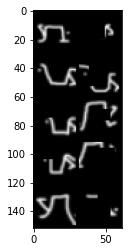

In [56]:
imgs = get_train_images(10)
grid = torchvision.utils.make_grid(imgs, nrow=2)
npimg = grid.numpy()
# npimg.shape
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

In [25]:
x_support[0][1].max()

tensor(0.9294)

In [18]:
F.dropout(x_support[0][1], p=.3).max()

tensor(1.2773)

In [24]:
enc = AE(1, 64, 64)

In [25]:
# Extract features (first dim is batch dim)
x = torch.cat([x_support, x_query], 1) # e.g. [1,50*(n_support+n_query),*(3,84,84)]
z, r = enc.forward(x)
z_support = z[:,:ways * 1] # e.g. [1,50*n_support,*(3,84,84)]
z_query = z[:,ways * 1:] # e.g. [1,50*n_query,*(3,84,84)]

r_supp = r[:,:ways * 1]
r_query = r[:,ways * 1:]

torch.Size([1, 200, 1, 28, 28])
torch.Size([200, 64])


In [26]:
z_support.shape

torch.Size([1, 50, 64])

In [27]:
r_supp.shape

torch.Size([1, 50, 1, 28, 28])

In [107]:
r_query.shape

torch.Size([1, 150, 1, 28, 28])

In [49]:
rs1 = r_supp.view(1, 50, 1, 1, 28, 28)[0][0]

In [52]:
rq1 = r_query.view(1, 50, 3, 1, 28, 28)[0][0]

In [88]:
F.mse_loss(rs1, rq1, reduction='none').sum()

/tmp/ipykernel_616/1915248140.py:1: UserWarning: Using a target size (torch.Size([3, 1, 28, 28])) that is different to the input size (torch.Size([1, 1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  F.mse_loss(rs1, rq1, reduction='none').sum()


tensor(6.7648e-10, grad_fn=<SumBackward0>)

In [81]:
a = (rs1[0]- rq1[0])

In [76]:
b = (rs1[0]- rq1[1])

In [78]:
c = (rs1[0]- rq1[2])

In [85]:
(a**2 + b ** 2+ c**2).sum(dim=[1,2])

tensor([6.7648e-10], grad_fn=<SumBackward1>)